In [1]:
import sys, os
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,AveragePooling2D
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.utils import np_utils
import cv2
import matplotlib.pyplot as plt

### Importing the dataset after preprocessing with datapreprocess.py

In [2]:
X_train=np.load('/content/drive/MyDrive/Dataset/kaggle dataset/emotion-recognition/X_train.npy')
Y_train=np.load('/content/drive/MyDrive/Dataset/kaggle dataset/emotion-recognition/Y_train.npy')
X_test=np.load('/content/drive/MyDrive/Dataset/kaggle dataset/emotion-recognition/X_test.npy')
Y_test=np.load('/content/drive/MyDrive/Dataset/kaggle dataset/emotion-recognition/Y_test.npy')

In [3]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((28709, 48, 48), (28709, 1), (7178, 48, 48), (7178, 1))

#### Mapping emotions and index

In [4]:
emotion_to_index = {'angry':0,
                   'disgust':1,
                   'fear':2,
                   'happy':3,
                   'neutral':4,
                   'sad':5,
                   'surprise':6}
index_to_emotion = {0: 'angry',
                    1: 'disgust',
                    2: 'fear',
                    3: 'happy',
                    4: 'neutral',
                    5: 'sad',
                    6: 'surprise'}

#### Viewing the dataset

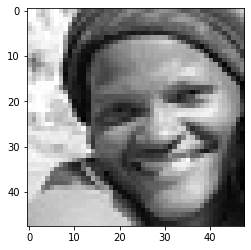

happy


In [5]:
i=39
plt.imshow(X_train[i,:,:], cmap="gray")
plt.show()
print(index_to_emotion[Y_train[i,0]])

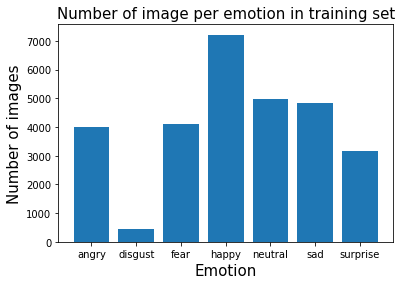

In [6]:
arr = np.zeros((7,))
for i in range(X_train.shape[0]):
    val = np.uint8(Y_train[i])
    arr[val] = arr[val] + 1

arr2 = np.reshape(arr, (-1))
plt.bar([0,1,2,3,4,5,6], arr2, )
plt.xlabel("Emotion", fontsize = 15)
plt.ylabel("Number of images", fontsize = 15)
plt.title("Number of image per emotion in training set", fontsize=15)
 
plt.xticks([0,1,2,3,4,5,6], emotion_to_index )
 
plt.show()

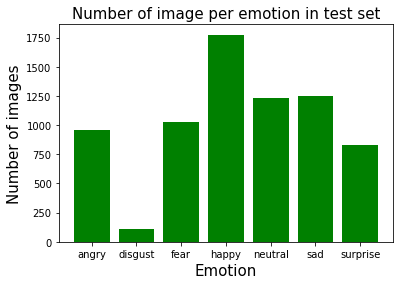

In [8]:
arr = np.zeros((7,))
for i in range(X_test.shape[0]):
    val = np.uint8(Y_test[i])
    arr[val] = arr[val] + 1

arr2 = np.reshape(arr, (-1))
plt.bar([0,1,2,3,4,5,6], arr2, color='g')
plt.xlabel("Emotion", fontsize = 15)
plt.ylabel("Number of images", fontsize = 15)
plt.title("Number of image per emotion in test set", fontsize=15)
 
plt.xticks([0,1,2,3,4,5,6], emotion_to_index )
 
plt.show()

#### As we can see data set is very imbalanced, so we will use F1 score as metric and not accuracy





### Performing One-hot encoding on labels

In [9]:
targets = np.array(Y_train).reshape(-1)
Y_train_one_hot = np.eye(7)[targets]
Y_train_one_hot.shape

(28709, 7)

In [12]:
targets = np.array(Y_test).reshape(-1)
Y_test_one_hot = np.eye(7)[targets]
Y_test_one_hot.shape

(7178, 7)

#### Reshaping the dataset to 4D and normalising it

In [13]:
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)

X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

In [14]:
X_train_nor=(X_train-127.0)/127
X_test_nor=(X_test-127.0)/128

In [16]:
X_train_nor[1,:,:,0]

array([[-0.42519685, -0.5511811 , -0.43307087, ...,  0.08661417,
         0.73228346,  1.        ],
       [-0.34645669, -0.30708661, -0.23622047, ...,  0.66929134,
         0.76377953,  0.96850394],
       [-0.23622047, -0.32283465, -0.18897638, ...,  0.54330709,
         1.00787402,  0.98425197],
       ...,
       [ 1.00787402,  0.8976378 ,  0.73228346, ...,  0.33858268,
         0.49606299,  0.8976378 ],
       [ 0.97637795,  0.96062992,  0.79527559, ...,  0.39370079,
         0.62204724,  0.8976378 ],
       [ 1.00787402,  1.00787402,  0.87401575, ...,  0.46456693,
         0.72440945,  0.86614173]])

# Creating th model 

In [19]:
model = Sequential()

model.add(Conv2D(16, kernel_size=(5, 5), activation='relu', input_shape=(X_train.shape[1:])))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))

model.add(Conv2D(32, (5, 5), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))

model.add(Conv2D(64, (4, 4), activation='relu'))

#fully connected
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(40, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(7, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 44, 44, 16)        416       
_________________________________________________________________
batch_normalization_2 (Batch (None, 44, 44, 16)        64        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 21, 21, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 17, 17, 32)        12832     
_________________________________________________________________
batch_normalization_3 (Batch (None, 17, 17, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 5, 5, 64)         

In [20]:
from keras.metrics import  Precision, Recall

In [21]:
model.compile(optimizer=Adam(), loss = categorical_crossentropy, metrics = [Precision(),
                                                                           Recall(),
                                                                           'accuracy'])

# Training the Model

In [27]:
history =model.fit(X_train_nor, Y_train_one_hot ,
          batch_size=64,
          epochs=75,
          verbose=1,
          validation_data=(X_test_nor, Y_test_one_hot),
          shuffle=True)

Epoch 1/75
449/449 [==============================] - 3s 8ms/step - loss: 0.4293 - precision: 0.8799 - recall: 0.7913 - accuracy: 0.8359 - val_loss: 1.6076 - val_precision: 0.6447 - val_recall: 0.5515 - val_accuracy: 0.5940
Epoch 2/75
449/449 [==============================] - 3s 7ms/step - loss: 0.4127 - precision: 0.8846 - recall: 0.8023 - accuracy: 0.8419 - val_loss: 1.6361 - val_precision: 0.6423 - val_recall: 0.5476 - val_accuracy: 0.5890
Epoch 3/75
449/449 [==============================] - 3s 7ms/step - loss: 0.4033 - precision: 0.8857 - recall: 0.8081 - accuracy: 0.8454 - val_loss: 1.6295 - val_precision: 0.6411 - val_recall: 0.5483 - val_accuracy: 0.5945
Epoch 4/75
449/449 [==============================] - 3s 7ms/step - loss: 0.4068 - precision: 0.8851 - recall: 0.8055 - accuracy: 0.8441 - val_loss: 1.6308 - val_precision: 0.6421 - val_recall: 0.5488 - val_accuracy: 0.5964
Epoch 5/75
449/449 [==============================] - 3s 7ms/step - loss: 0.4080 - precision: 0.8842 - r

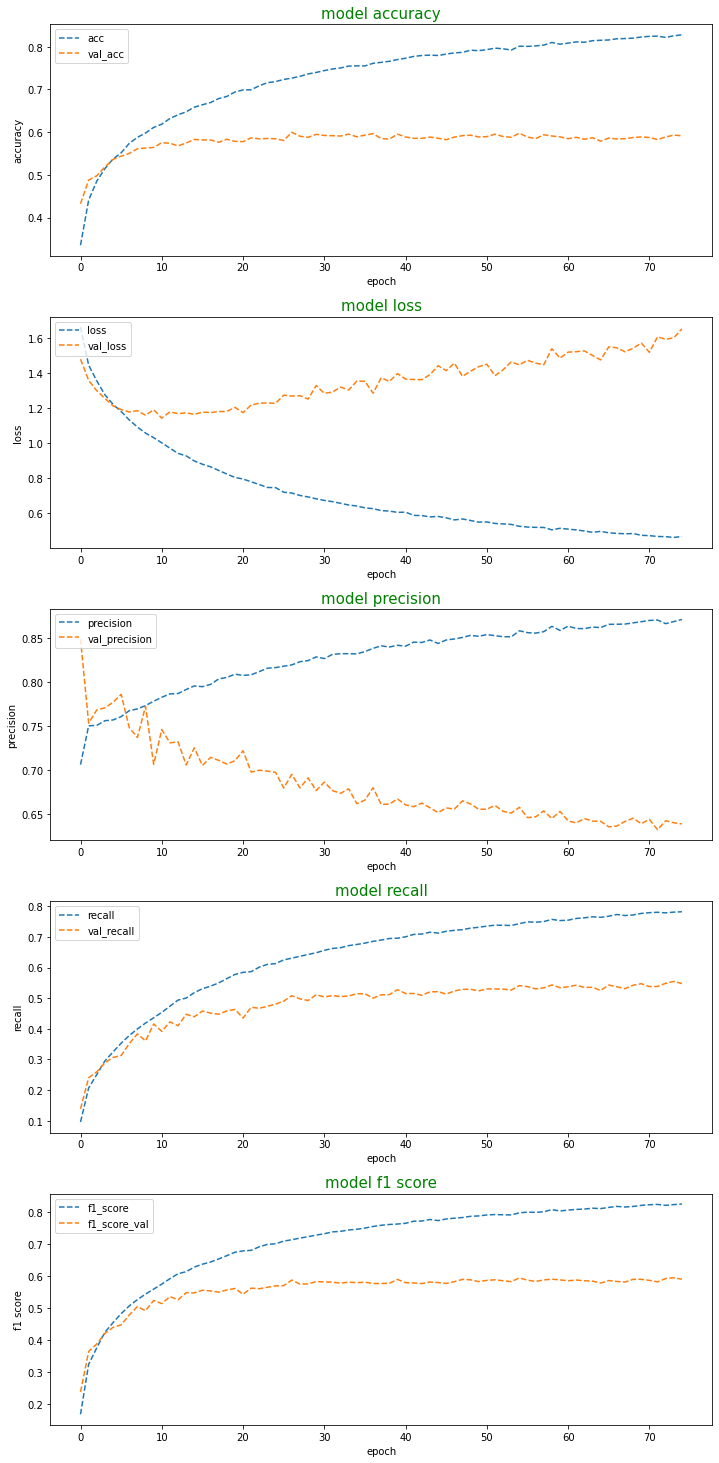

In [ ]:
num = 3
prec = f"precision_{num}"
rec = f"recall_{num}"
valprec = f"val_precision_{num}"
valrec = f"val_recall_{num}"
 
 
plt.figure(figsize=(10,20))
 
plt.subplot(511)
plt.plot(history.history['accuracy'], '--', label='acc')
plt.plot(history.history['val_accuracy'], '--',label='val_acc')
plt.title('model accuracy',fontsize=15, color='green')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
#axes=plt.gca()
#axes.set_ylim([0.965, 1])
plt.tight_layout(h_pad=3.0)
 
 
plt.subplot(512)
plt.plot(history.history['loss'], '--', label='loss')
plt.plot(history.history['val_loss'], '--',label='val_loss')
plt.title('model loss',fontsize=15, color='green')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
 
plt.subplot(513)
plt.plot(history.history[prec], '--', label='precision')
plt.plot(history.history[valprec], '--',label='val_precision')
plt.title('model precision',fontsize=15, color='green')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(loc='upper left')
 
plt.subplot(514)
plt.plot(history.history[rec], '--', label='recall')
plt.plot(history.history[valrec], '--',label='val_recall')
plt.title('model recall',fontsize=15, color='green')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(loc='upper left')
 
precision = history.history[prec]
recall = history.history[rec]
precval = history.history[valprec]
recval = history.history[valrec]
f1 = [(2*a*b)/(a+b) for a,b in zip(precision, recall)]
f1_val = [(2*a*b)/(a+b+1e-7) for a,b in zip(precval, recval)]
 
plt.subplot(515)
plt.plot(f1, '--', label='f1_score')
plt.plot(f1_val, '--',label='f1_score_val')
plt.title('model f1 score',fontsize=15,color='green')
plt.ylabel('f1 score')
plt.xlabel('epoch')
plt.legend(loc='upper left')
 
plt.show()

In [28]:
from sklearn.metrics import classification_report
print('\nClassification Report for training\n')
preds = model.predict(X_train_nor)
y_pred = np.argmax(preds, axis=1)
print(classification_report(Y_train, y_pred, target_names=emotion_to_index))
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(Y_train, y_pred)
print('Confusion Matrix\n')
print(confusion)

from sklearn.metrics import classification_report
print('\nClassification Report for test\n')
preds = model.predict(X_test_nor)
y_pred = np.argmax(preds, axis=1)
print(classification_report(Y_test, y_pred, target_names=emotion_to_index))
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(Y_test, y_pred)
print('Confusion Matrix\n')
print(confusion)


Classification Report for training

              precision    recall  f1-score   support

       angry       0.99      0.97      0.98      3995
     disgust       0.99      0.97      0.98       436
        fear       0.97      0.97      0.97      4097
       happy       0.99      0.99      0.99      7215
     neutral       0.98      0.98      0.98      4965
         sad       0.96      0.98      0.97      4830
    surprise       0.99      0.99      0.99      3171

    accuracy                           0.98     28709
   macro avg       0.98      0.98      0.98     28709
weighted avg       0.98      0.98      0.98     28709

Confusion Matrix

[[3865    3   34    1   23   67    2]
 [   1  425    5    1    1    2    1]
 [  22    1 3993    1    7   58   15]
 [   6    0    7 7170   18    8    6]
 [   7    0   12   23 4879   41    3]
 [   9    0   41    4   37 4739    0]
 [   3    0   26   11    4    0 3127]]

Classification Report for test

              precision    recall  f1-score   su

In [29]:
model.save('best0.h5')